In [1]:
from scipy.spatial.distance import cosine
import numpy as np
import pandas as pd
import seaborn as sns
import h5py
import umap
import hdbscan
import networkx as nx
from node2vec import Node2Vec
from TDAembedding import TDAembedding
from sbm_utils import generate_clusters
import matplotlib.pyplot as plt
from scipy.io import savemat,loadmat
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Generate data

Лежат в папках test_matrices, посчитанные интервалы лежат в ints

In [113]:
from sbm_utils import wsbm_built_in_block, wsbm_crossed_blocks, generate_wsbm_adj, generate_clusters

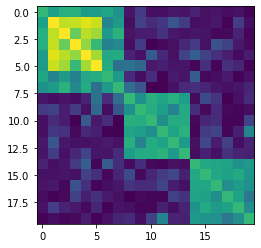

In [115]:
n=20
pi_vector=[0.4,0.3,0.3]
theta_in=2
theta_out=-2
n_blocks=[1,3]
enh_params=[1.5,2]
wAdj=generate_wsbm_adj(n,pi_vector,theta_in,theta_out)
wAdj_emb=wsbm_built_in_block(n,pi_vector,wAdj,n_blocks,enh_params)
wAdj_emb = wAdj_emb/np.max(wAdj_emb)
plt.imshow(wAdj_emb)
savemat(f"{n}_wsbm_embedded.mat",mdict={"wsbm_emb":wAdj_emb})

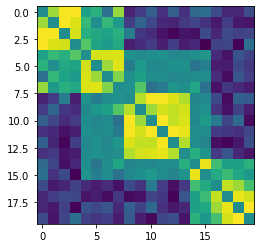

In [125]:
n=20
pi_vectors=[[0.4,0.3,0.3],[0.2,0.6,0.2]]
theta_ins=[3,3]
theta_outs=[-3,-1]
wAdj_mixed=wsbm_crossed_blocks(n,pi_vectors,theta_ins,theta_outs)
plt.imshow(wAdj_mixed)
wAdj_mixed = wAdj_mixed/np.max(wAdj_mixed)
savemat(f"{n}_wsbm_mixed.mat",mdict={"wsbm_mixed":wAdj_mixed})

In [ ]:
pi_vector=[0.4,0.3,0.3]
theta_in=3
theta_out=-3
wAdj = generate_wsbm_adj(n,[0.4,0.3,0.3],theta_in = theta_in,theta_out = theta_out)
plt.imshow(wAdj)
savemat(f"{n}_wsbm_base_{pi_vector[0]}_{pi_vector[1]}_{theta_in}_{abs(theta_out)}.mat",mdict={f"wsbm_base":wAdj})

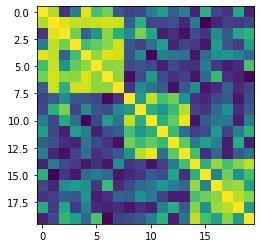

In [130]:
pi_vector=[0.4,0.3,0.3]
theta_in=1
theta_out=-1
wAdj = generate_wsbm_adj(n,[0.4,0.3,0.3],theta_in = theta_in,theta_out = theta_out)
plt.imshow(wAdj)
savemat(f"{n}_wsbm_base_{pi_vector[0]}_{pi_vector[1]}_{theta_in}_{abs(theta_out)}.mat",mdict={f"wsbm_base":wAdj})

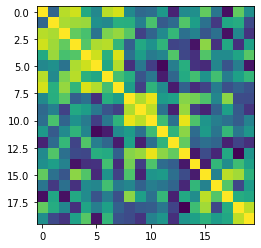

In [131]:
pi_vector=[0.4,0.3,0.3]
theta_in=1
theta_out=-0.5
wAdj = generate_wsbm_adj(n,[0.4,0.3,0.3],theta_in = theta_in,theta_out = theta_out)
plt.imshow(wAdj)
savemat(f"{n}_wsbm_base_{pi_vector[0]}_{pi_vector[1]}_{theta_in}_{abs(theta_out)}.mat",mdict={f"wsbm_base":wAdj})

# Comparing embedding node2vec and TDA with UMAP
все модели показаны на игрушечных матрицах из 20 компонент, и генерация была везде 0.4, 0.3, 0.3

In [5]:
target = generate_clusters(20, pi_vector=[0.4,0.3,0.3]).astype('int')

### Utils functions 
For node2vec and TDA embedding with drawing in UMAP

In [31]:
def draw_node2vec(matrix, target,n_neighbors = 8, nettype = "Basic strong blocks",annotate = False):
    graph = nx.from_numpy_matrix(matrix)
    node2vec = Node2Vec(graph, dimensions=25, walk_length=15, p=0.5,q=1, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    nodes = [str(node) for node in range(matrix.shape[0])]
    vecs = []
    for node in nodes:
        vecs.append(model.wv.__getitem__([node]))
    node2vec_ebds = np.squeeze(np.array(vecs))   
    reducer = umap.UMAP(n_neighbors=n_neighbors, metric = 'cosine', n_components=2)
    u_emb = reducer.fit_transform(node2vec_ebds)
    plt.scatter(u_emb[:, 0], u_emb[:, 1], c=target, cmap='viridis', s=25)
    plt.colorbar(boundaries=np.arange(4)-0.5).set_ticks(np.arange(3))
    if annotate:
        for i, txt in enumerate(nodes):
            plt.annotate(txt, (u_emb[i, 0], u_emb[i, 1]))
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'UMAP projection of the node2vec embedding: \n{nettype}', fontsize=14);
    plt.savefig('imgs/'+'Node2vec_'.join(nettype.split())+'.png')
    plt.show()
    return u_emb, node2vec_ebds

def find_TDA_embded(path_to_int, num_nodes):
    embd = TDAembedding(path_to_int, num_nodes=num_nodes)
    intervals = embd.read_intervals(h0=True, h1=True)
    df0 = embd.create_h0_embedding(intervals=intervals)
    df1 = embd.create_h1_embedding(intervals=intervals)
    return embd
def draw_TDA_umap(target, df0 = None, df1 = None, nettype = "Basic strong blocks", n_neighbors = 7, metric = 'cosine', annotate = False):
    
    reducer = umap.UMAP(n_neighbors=n_neighbors, metric = metric, n_components=2)
    u_emb0 = reducer.fit_transform(df0.values)
    reducer = umap.UMAP(n_neighbors=n_neighbors, metric = metric, n_components=2)
    u_emb1 = reducer.fit_transform(df1.values)

    nodes = [str(node) for node in range(len(target))]
    plt.figure(figsize = (12,5))
    plt.subplot(1,2,1);
    plt.scatter(u_emb0[:, 0], u_emb0[:, 1], c=target, cmap='viridis', s=25)
    plt.colorbar(boundaries=np.arange(4)-0.5).set_ticks(np.arange(3))
    for i, txt in enumerate(nodes):
        plt.annotate(txt, (u_emb0[i, 0], u_emb0[i, 1]))
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'UMAP projection of the h0 embedding: \n{nettype}', fontsize=14);
    plt.subplot(1,2,2);
    plt.scatter(u_emb1[:, 0], u_emb1[:, 1], c=target, cmap='viridis', s=25)
    plt.colorbar(boundaries=np.arange(4)-0.5).set_ticks(np.arange(3))
    if annotate:
        for i, txt in enumerate(nodes):
            plt.annotate(txt, (u_emb1[i, 0], u_emb1[i, 1]))
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'UMAP projection of the h1 embedding: \n{nettype}', fontsize=14);
    plt.savefig('imgs/'+'TDA_'.join(nettype.split())+'.png')

    plt.show()
    return u_emb0, u_emb1
def get_short(value_short, df1 = None):
    names = list(df1.columns)[:-2]
    short = [i for i,name in enumerate(names) if float(name.split()[0].split('-')[0]) < value_short]
    long= [i for i,name in enumerate(names) if float(name.split()[0].split('-')[0]) >= value_short]

    return short, long

In [58]:
#target

## Strong blocks

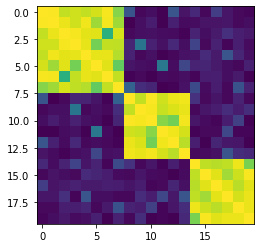

In [3]:
wAdj = loadmat("test_matrices/20_wsbm_base_0.4_0.3_3_3.mat")['wsbm_base']
plt.imshow(wAdj)

### Node2vec Embedding

Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 739.97it/s]


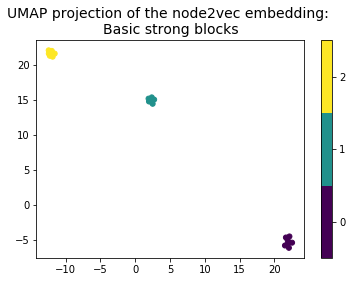

In [17]:
u_emb, node2vec_ebds  = draw_node2vec(wAdj,target,n_neighbors = 8, nettype = "Basic strong blocks")

### TDA embedding

In [18]:
n=20
path_to_int = f"ints/ints_{n}_strong.txt"
emb = find_TDA_embded(path_to_int, num_nodes=n)

Text(0.5, 1.0, 'Distribution of length of cycles')

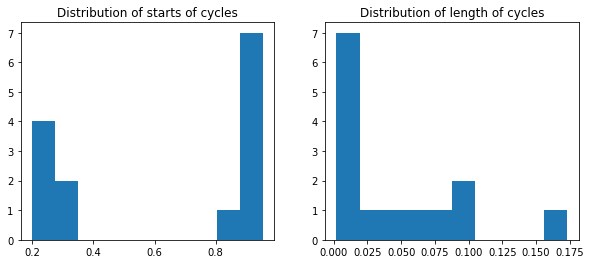

In [19]:
cstart, clength = list(zip(*emb.cycles[:]))
plt.figure(figsize = (10,4))
plt.subplot(1,2,1); plt.hist(cstart);plt.title('Distribution of starts of cycles')
plt.subplot(1,2,2); plt.hist(clength); plt.title('Distribution of length of cycles')
#idxs_short, idxs_long = get_short(0.4, df1 = df1)

In [13]:
df0 = emb.h0embedding
df1 = emb.h1embedding

In [14]:
idxs_short, idxs_long = get_short(0.4, df1 = df1)

In [ ]:
hamming
jaccard
dice
russellrao
kulsinski
rogerstanimoto
sokalmichener
sokalsneath
yule

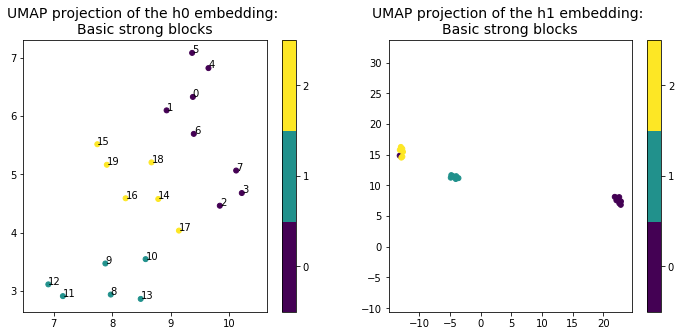

In [39]:
u_emb0, u_emb1 = draw_TDA_umap(target, df0, df1.iloc[:,idxs_short], n_neighbors = 4, nettype = "Basic strong blocks", metric = 'cosine', annotate=False)

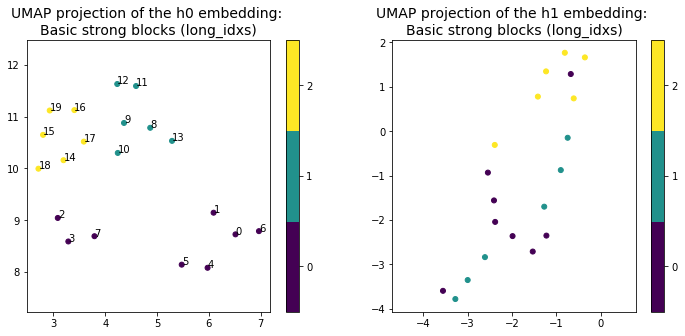

In [29]:
u_emb0, u_emb1 = draw_TDA_umap(target, df0, df1.iloc[:,idxs_long], n_neighbors = 5, nettype = "Basic strong blocks (long_idxs)", annotate=False)

In [40]:
df1.iloc[:,idxs_long]

,"0.781-0.954, 0.173","0.827-0.930, 0.103","0.855-0.859, 0.004","0.857-0.946, 0.089","0.863-0.943, 0.080","0.898-0.930, 0.032","0.903-0.940, 0.037","0.931-0.933, 0.002"
0,0,0,1,0,0,0,1,0
1,1,0,0,1,1,0,0,0
2,1,1,1,1,1,0,1,0
3,1,1,1,1,0,0,1,0
4,1,0,0,1,1,0,0,0
5,1,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0
7,0,1,1,0,1,0,1,0
8,1,1,1,0,0,0,0,0
9,1,1,0,1,0,0,0,1


## Medium blocks

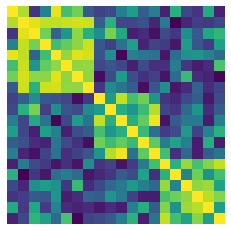

In [41]:
#wAdj = loadmat("wsbm_base_0.4_0.3_1_1.mat")['wsbm_base']
wAdj = loadmat("test_matrices/20_wsbm_base_0.4_0.3_1_1.mat")['wsbm_base']

plt.imshow(wAdj); plt.axis('off')
plt.savefig('MediumBlocks.png')

Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 729.37it/s]


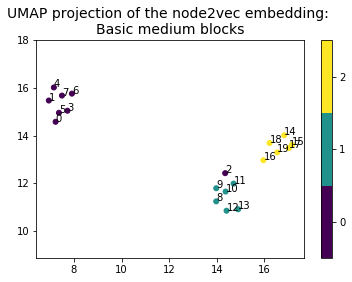

In [62]:
u_emb, node2vec_ebds  = draw_node2vec(wAdj,target,nettype = "Basic medium blocks", n_neighbors = 8, annotate = True)

In [46]:
path_to_int =  f"ints/ints_{n}_medium.txt"
emb = find_TDA_embded(path_to_int, num_nodes = n)
df0 = emb.h0embedding
df1 = emb.h1embedding

Text(0.5, 1.0, 'Distribution of length of cycles')

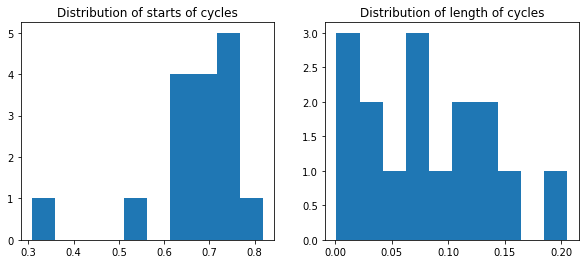

In [47]:
cstart, clength = list(zip(*emb.cycles[:]))
plt.figure(figsize = (10,4))
plt.subplot(1,2,1); plt.hist(cstart);plt.title('Distribution of starts of cycles')
plt.subplot(1,2,2); plt.hist(clength); plt.title('Distribution of length of cycles')


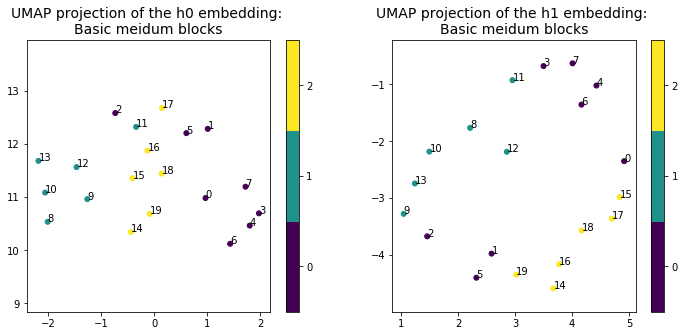

In [63]:
idxs_short, idxs_long = get_short(0.7, df1 = df1)
u_emb0, u_emb1 = draw_TDA_umap(target, df0.iloc[:,:-2], df1.iloc[:,idxs_short], n_neighbors = 5, nettype = "Basic meidum blocks", annotate=True)

In [64]:
df1

,"0.276-0.308, 0.032","0.423-0.535, 0.112","0.545-0.750, 0.205","0.565-0.664, 0.099","0.581-0.653, 0.072","0.592-0.743, 0.151","0.597-0.735, 0.138","0.606-0.742, 0.136","0.616-0.694, 0.078","0.626-0.659, 0.033","0.644-0.694, 0.050","0.652-0.653, 0.001","0.659-0.740, 0.081","0.685-0.697, 0.012","0.688-0.703, 0.015","0.707-0.818, 0.111",num_ints,mean_int
0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,3,0.018562
1,1,0,1,1,1,1,1,0,0,1,0,1,1,1,1,1,12,0.059375
2,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,5,0.029750
3,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,0.005125
4,1,0,0,0,0,0,1,0,0,0,0,1,1,1,0,1,6,0.023437
5,0,0,1,1,1,1,1,0,0,1,0,1,0,1,1,1,10,0.052313
6,1,0,0,1,0,0,1,0,0,0,0,1,1,1,0,1,7,0.029625
7,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,4,0.014062
8,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,2,0.017938
9,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,3,0.023187


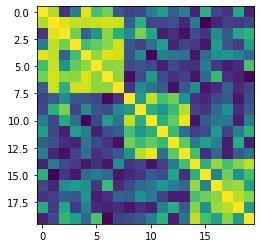

In [105]:
plt.imshow(wAdj); 

## Super weak model

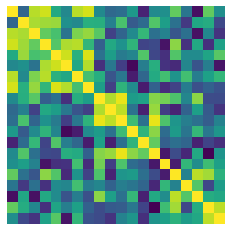

In [66]:
wAdj = loadmat("test_matrices/20_wsbm_base_0.4_0.3_1_0.5.mat")['wsbm_base']
plt.imshow(wAdj); plt.axis('off')
plt.savefig('SuperWeakBlocks.png')

Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 795.32it/s]


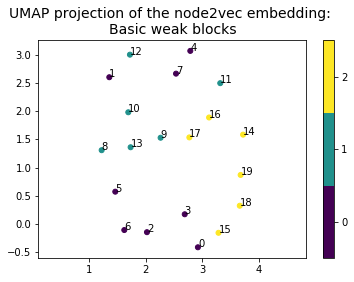

In [67]:
u_emb, node2vec_ebds  = draw_node2vec(wAdj,target,nettype = "Basic weak blocks", n_neighbors = 8, annotate = True)

In [68]:
path_to_int =  f"ints/ints_{n}_weak.txt"
emb = find_TDA_embded(path_to_int, num_nodes = n)
df0 = emb.h0embedding
df1 = emb.h1embedding

Text(0.5, 1.0, 'Distribution of length of cycles')

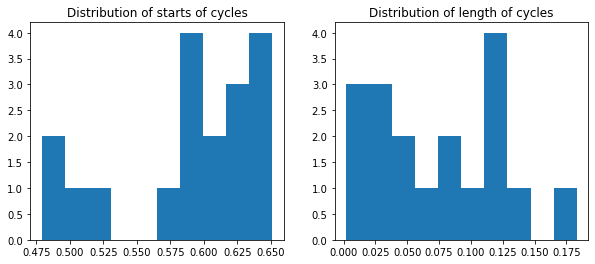

In [69]:
cstart, clength = list(zip(*emb.cycles[:]))
plt.figure(figsize = (10,4))
plt.subplot(1,2,1); plt.hist(cstart);plt.title('Distribution of starts of cycles')
plt.subplot(1,2,2); plt.hist(clength); plt.title('Distribution of length of cycles')

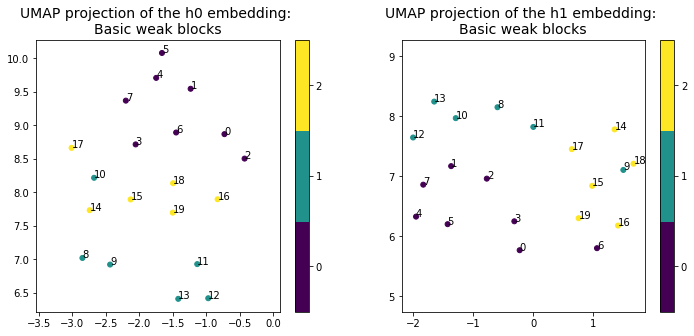

In [74]:
idxs_short, idxs_long = get_short(0.6, df1 = df1)
u_emb0, u_emb1 = draw_TDA_umap(target, df0.iloc[:,:], df1.iloc[:,idxs_short], n_neighbors = 6, nettype = "Basic weak blocks", annotate=True)

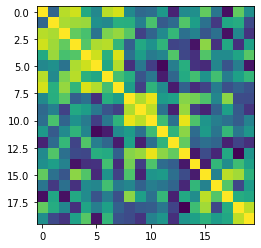

In [75]:
plt.imshow(wAdj); 

## Mixed Model

In [76]:
wAdj = loadmat("test_matrices/20_wsbm_mixed.mat")
#wAdj

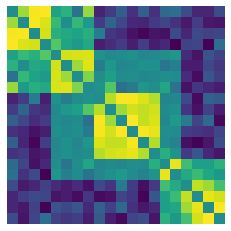

In [77]:
wAdj_mixed = loadmat("test_matrices/20_wsbm_mixed.mat")['wsbm_mixed']
plt.imshow(wAdj_mixed); plt.axis('off')
plt.savefig('MixedBlocks.png')

Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 666.29it/s]


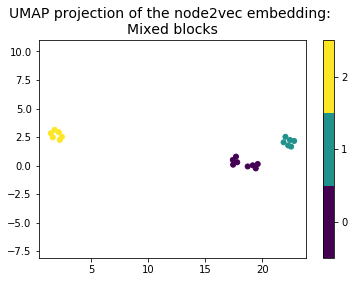

In [78]:
u_emb, node2vec_ebds = draw_node2vec(wAdj_mixed, target, nettype = "Mixed blocks", n_neighbors = 8)

In [79]:
path_to_int =  f"ints/ints_{n}_mixed.txt"
emb = find_TDA_embded(path_to_int, num_nodes = n)
df0 = emb.h0embedding
df1 = emb.h1embedding

Text(0.5, 1.0, 'Distribution of length of cycles')

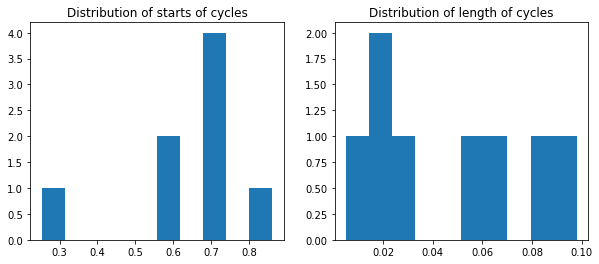

In [80]:
cstart, clength = list(zip(*emb.cycles[:]))
plt.figure(figsize = (10,4))
plt.subplot(1,2,1); plt.hist(cstart);plt.title('Distribution of starts of cycles')
plt.subplot(1,2,2); plt.hist(clength); plt.title('Distribution of length of cycles')

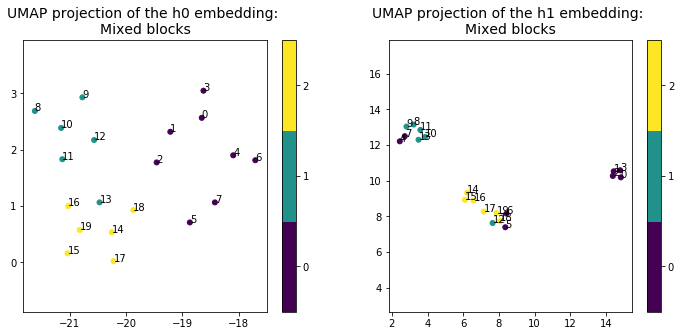

In [85]:
idxs_short, idxs_long = get_short(0.7, df1 = df1)
u_emb0, u_emb1 = draw_TDA_umap(target, df0.iloc[:,:-2], df1.iloc[:,idxs_short], n_neighbors = 6, nettype = "Mixed blocks", annotate=True)

In [86]:
df1

,"0.223-0.253, 0.030","0.502-0.600, 0.098","0.554-0.611, 0.057","0.630-0.697, 0.067","0.663-0.681, 0.018","0.679-0.697, 0.018","0.684-0.689, 0.005","0.781-0.862, 0.081",num_ints,mean_int
0,1,1,0,0,0,0,0,1,3,0.026125
1,1,0,0,0,0,0,0,0,1,0.003750
2,1,0,0,0,0,0,0,0,1,0.003750
3,1,1,0,0,0,0,0,1,3,0.026125
4,0,1,0,0,0,1,1,0,3,0.015125
5,0,0,0,0,0,0,0,0,0,0.000000
6,0,0,0,0,0,0,0,0,0,0.000000
7,0,1,0,1,0,1,1,1,5,0.033625
8,0,0,0,0,0,0,1,0,1,0.000625
9,0,0,0,1,0,0,1,0,2,0.009000


## Embed Model

In [87]:
wAdj_emb = loadmat("test_matrices/20_wsbm_embedded.mat")['wsbm_emb']

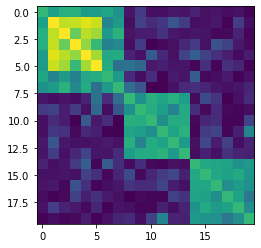

In [88]:
plt.imshow(wAdj_emb); 
plt.savefig('EmbeddedBlocks.png')

Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 749.83it/s]


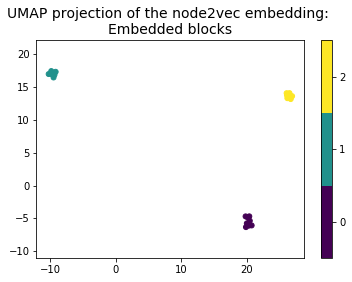

In [89]:
u_emb, node2vec_ebds = draw_node2vec(wAdj_emb, target,n_neighbors = 8, nettype = "Embedded blocks")

In [90]:
path_to_int =  f"ints/ints_{n}embed.txt"
emb = find_TDA_embded(path_to_int, num_nodes = n)
df0 = emb.h0embedding
df1 = emb.h1embedding

Text(0.5, 1.0, 'Distribution of length of cycles')

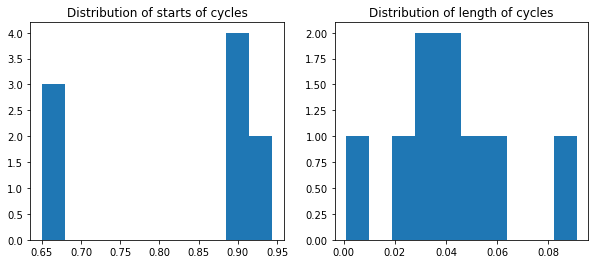

In [91]:
cstart, clength = list(zip(*emb.cycles[:]))
plt.figure(figsize = (10,4))
plt.subplot(1,2,1); plt.hist(cstart);plt.title('Distribution of starts of cycles')
plt.subplot(1,2,2); plt.hist(clength); plt.title('Distribution of length of cycles')

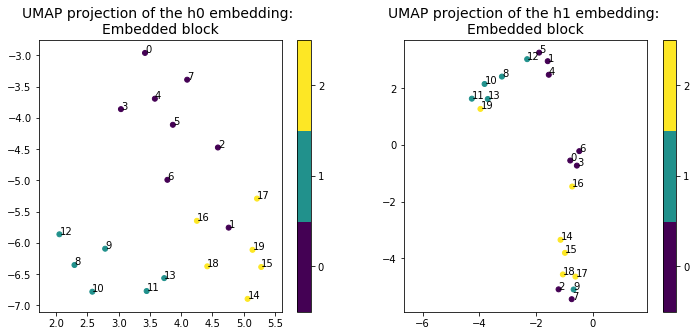

In [95]:
idxs_short, idxs_long = get_short(0.89, df1 = df1)
u_emb0, u_emb1 = draw_TDA_umap(target, df0.iloc[:,:], df1.iloc[:,idxs_short], n_neighbors = 5, nettype = "Embedded block", annotate=True)

In [99]:
#можно легко выделить сильный блок 2-3-4-5
df0

,0.284,0.293,0.307,0.594,0.595,0.605,0.605,0.608,0.613,0.615,0.618,0.620,0.627,0.632,0.648,0.676,0.741,0.785
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,1,1
9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [96]:
df1

,"0.635-0.670, 0.035","0.642-0.664, 0.022","0.649-0.650, 0.001","0.834-0.925, 0.091","0.843-0.903, 0.060","0.855-0.893, 0.038","0.861-0.907, 0.046","0.878-0.906, 0.028","0.900-0.944, 0.044",num_ints,mean_int
0,1,0,0,0,0,0,0,0,0,1,0.003889
1,1,0,0,1,1,1,1,0,1,6,0.034889
2,0,0,0,0,0,0,0,0,0,0,0.000000
3,1,0,0,0,0,0,1,0,0,2,0.009000
4,0,0,0,1,1,0,1,0,1,4,0.026778
5,1,0,0,1,1,1,0,0,0,4,0.024889
6,1,0,0,0,0,0,0,0,0,1,0.003889
7,0,0,0,0,0,0,0,0,0,0,0.000000
8,0,1,0,1,1,1,0,1,0,5,0.026556
9,0,0,0,0,0,0,0,0,0,0,0.000000
